### Import libraries

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils.data_utils import connect_to_db

### Connect to Database

In [284]:
engine, inspector, tables_in_db = connect_to_db()
print(f"Available tables: {tables_in_db}")

INFO:root:SQL engine is created.
INFO:root:2 tables found inside database viabill.db


Available tables: ['customers', 'transactions']


### Load extension for SQL queries

In [3]:
%load_ext sql

In [4]:
%sql sqlite:///data/viabill.db

### Make sure we can query tables with SQL

In [5]:
%%sql
SELECT * FROM customers
LIMIT 5

 * sqlite:///data/viabill.db
Done.


customerID,sex,age,residentialAddress,postalAddress,income
1,1,25,28 Irvine Place,28 Irvine Place,None
2,1,19,72 Bertha Street,72 Bertha Street,43200
3,2,22,63 Ladberry Street,63 Ladberry Street,70200
4,0,24,98 Linneman Close,98 Linneman Close,93900
5,1,53,56 Salonica Road,56 Salonica Road,77000


In [6]:
%%sql
SELECT count(*), count(distinct customerID) FROM customers

 * sqlite:///data/viabill.db
Done.


count(*),count(distinct customerID)
500000,500000


In [7]:
%%sql
SELECT * FROM transactions
LIMIT 5

 * sqlite:///data/viabill.db
Done.


transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4
1,114,2869,140,0,0,0,0
2,855,124077,70,0,0,0,0
3,752,86184,85,0,0,0,0
4,246,248861,43,1,0,0,0
5,973,162112,127,0,0,0,0


In [70]:
%%sql
SELECT count(*), count(distinct transactionID) FROM transactions

 * sqlite:///data/viabill.db
Done.


count(*),count(distinct transactionID)
2000000,2000000


### Task 1 and 2

**1.Select transactions that you use as credit applications (write SQL query):**
    
a. select the last transaction (transactionID increases with time) for each customer in Transaction table <br>
b. join result from previous point with customer Income - if Income is Missing replace it with -999 value

**2.Create a new feature based on transaction data - using Python or/and SQL:**

a. create “trans_price_avg_lst3” – for credit applications (transactions selected in point 1)
calculate a value that present an average price of 3 previous transactions

In [21]:
%%sql
WITH last_transaction as (
        SELECT customerID, max(transactionID) as last_transactionID
        FROM transactions
        GROUP BY customerID
),

last_three_transactions as (
        SELECT t.*, avg(price) OVER (PARTITION BY t.customerID ORDER BY transactionID ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) as trans_price_avg_lst3
        FROM transactions t
)

SELECT  t.*, 
        CASE WHEN cust.income is null then -999 else cust.income end as income
        
FROM last_three_transactions t
INNER JOIN last_transaction lt
    ON t.customerID = lt.customerID AND t.transactionID = lt.last_transactionID
INNER JOIN customers cust
    ON t.customerID = cust.customerID
ORDER BY t.customerID
LIMIT 10

 * sqlite:///data/viabill.db
Done.


transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,trans_price_avg_lst3,income
1697842,248,1,147,0,0,0,0,119.33333333333333,-999
1834257,392,2,150,0,0,0,0,98.33333333333333,43200
1974624,396,3,140,0,0,0,0,114.33333333333333,70200
1536291,544,4,136,0,1,0,0,None,93900
661121,984,5,181,0,0,0,0,64.33333333333333,77000
1964705,533,6,33,0,0,0,0,190.0,77500
313094,759,7,195,0,0,0,0,None,13600
1848871,123,9,31,0,0,0,0,105.5,2700
1854937,461,10,5,0,0,0,2,90.33333333333333,80000
696173,447,11,42,0,0,0,0,133.5,57000


*NOTE:* Both tasks were done in one query. Notice, that `trans_price_avg_lst3` may contain None values, which means that for this customerIDs the last transaction is actually the  first one. That's why we can not calculate average value of three previous transactions, as there are no such. Additional suggestion may be to round values to 2 decimals.

### Task 3

Check if there is a dependency between age and sex in the data – use statistical test if applicable.

To check the dependancy between two variables we may check correlation between them and in our case plot a distribution of `Age` depending on `Sex`. For simplicity I'll read `customers` table with Pandas.

In [27]:
customers = pd.read_sql_table("customers", con=engine)
print(customers.shape)
customers.head(3)

(500000, 6)


,customerID,sex,age,residentialAddress,postalAddress,income
0,1,1,25,28 Irvine Place,28 Irvine Place,NaN
1,2,1,19,72 Bertha Street,72 Bertha Street,43200.0
2,3,2,22,63 Ladberry Street,63 Ladberry Street,70200.0


In [29]:
# fast data types check
customers.dtypes

customerID              int64
sex                     int64
age                     int64
residentialAddress     object
postalAddress          object
income                float64
dtype: object

In [30]:
# fast missing check
customers.isnull().sum()

customerID               0
sex                      0
age                      0
residentialAddress       0
postalAddress            0
income                9975
dtype: int64

In [32]:
# basic stats
customers[["age", "sex"]].describe()

,age,sex
count,500000.000000,500000.000000
mean,44.630508,1.150402
std,16.178283,0.477797
min,5.000000,0.000000
25%,27.000000,1.000000
50%,50.000000,1.000000
75%,58.000000,1.000000
max,90.000000,2.000000


Correlation seems to be not high.

In [33]:
customers[["age", "sex"]].corr(method="spearman")

,age,sex
age,1.000000,0.001564
sex,0.001564,1.000000


As we may see the distribution of `Age` for different `Sex` levels is almost the same. So, **seems like there is no dependancy between age and sex in the data.** But, worth noticing, there is some strange gap sowhere in between 20 and 60 years old. For some reason people of average age tend to not use ViaBill services.

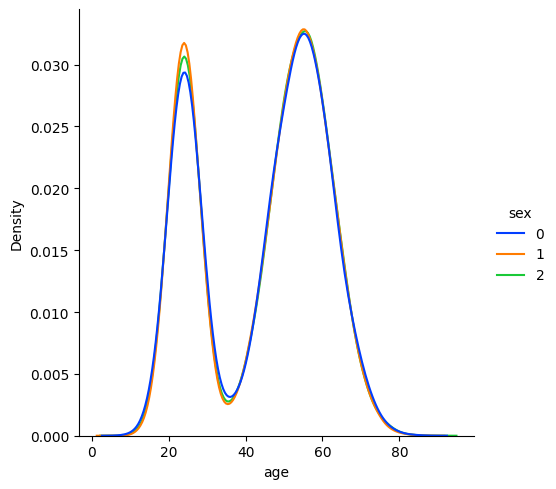

In [61]:
sns.displot(customers, x="age", hue="sex", kind="kde", common_norm=False, palette=sns.color_palette("bright", 3));

### Task 4

We want to send adequate marketing communication to customer – propose customers segments that we could use when we want to send emails with offers.

The task seems to be not very precise. What does it mean adequate marketing communication? What is a content of this offer? What is assumed target group of this capmpaign? Is it for young people or maybe for elder ones? Maybe we want to attract more clients to our partnering stores in beauty industry, so maybe we should target women? Seems like we need to make some assumptions. I propose some general brainstorming points, which may emphasize some important factors which may be considered during segmentation, depending on our business goal.<br>

* First, we should probably be careful with clients who had any delinquencies using our services. I would rather put them in a separate basket as a group of clients we at some point want to avoid. It can be a group of only defaulted clients, or stricter rule, like somebody who was late with the installment at some point (or late at least for more than couple of days).
* Second, there are clients who regularly use our service or those who used it once or maybe two times. We may ask ourselves, what do we want to achieve? Do we want to contact our regular clients expecting to have higher positive reaction, because of their loyalty or we want to encourage less active users to come back to our service?
* Third, there are clients who spend more on average than others, ViaBill seems to be interested in more expensive transactions to maximize merchant's fee. So, maybe we want to target those who tend to pay more.
* Four, demographic factors. Maybe for some reason we may want to target some age/sex/location group. It may be anything depending on our goal.

Let's assume, ViaBill decided to arrange a marketing campaign to increase sales for new-comming partnering companies from beauty industry which sale luxury cosmetics. Let's assume from analysis we see, that women tend to spend more for beauty-related products. Moreover, probably women elder than 40 years old on average have higher financial possibilities and spend more (on average) on products incl. cosmetics. So, we may target our campaign for women elder than 40, or maybe we may try out men over 40 years old, who may potentially buy smth for their wives or girlfriends.

**What next?**
Should we send the emails to every client > 40 years old? The short answer is - it depends. First of all, we should consider the cost of such email campaign, if it's very low, than we may consider sending marketing communication to even every client. Why not? Additionally, some clients may find our marketing communication offensive and decide to never use ViaBill services again. So, what if we need to optimize our campaign in terms of costs, avoid sending communication to those who will do what we expect anyway and to limit churn rate because of it. We may use A/B test, which is commonly used in Marketing. Plus to this after a while we may build a model trying to identify clients who will probably positively respond to it. So, the loop is the following:

* Split a sample of clients as randomly as possible, both samples should be as similar as possible. Remember avoiding clients who tend to default.
* Now we have group A and group B. Let B to be a smaller sample, just to test our campaign. Send marketing communication to clients from this sample B.
* After a while, analyze the results. Is the purchase rate with ViaBill significantly higher than in sample A?
* Let's build a model, for example `Uplift model` trying to identify which features help us to segment our clients and who of them tend to positively respond to the campaign.
* Use our model to approximate purchase probability for different clients and send communication to a group with the higher one.

### Task 5

Perform exploratory data analysis (EDA) and present interesting findings related to credit risk.

#### Reading sample

*NOTE:* There are records in transactions table, where customerID is empty. We'll drop them, because we're not able to identify the customer.

In [82]:
%%sql
SELECT count(*) FROM transactions
WHERE customerID = ''

 * sqlite:///data/viabill.db
Done.


count(*)
20017


In [81]:
sql_query = '''
         SELECT t.*,
         sex, 
         age, 
         residentialAddress, 
         postalAddress,
         income
         
         FROM transactions t
         LEFT JOIN customers cust
         ON t.customerID = cust.customerID
         WHERE t.customerID != ''
'''
df = pd.read_sql(sql_query, con=engine)
print(df.shape)
df.head()

(1979983, 13)


,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income
0,1,114,2869,140,0,0,0,0,2,24,74 Ada Street,74 Ada Street,54900.0
1,2,855,124077,70,0,0,0,0,1,46,23 Brampton Street,23 Brampton Street,60000.0
2,3,752,86184,85,0,0,0,0,1,52,96 Avon Street,35 Spurwood Street,7100.0
3,4,246,248861,43,1,0,0,0,1,29,3 Merinda Street,3 Merinda Street,67600.0
4,5,973,162112,127,0,0,0,0,2,30,64 Distribution Street,64 Distribution Street,92000.0


#### General EDA

In [83]:
df.describe()

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,income
count,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.940494e+06
mean,1.000054e+06,5.492294e+02,2.500951e+05,1.015208e+02,1.175833e-01,1.473851e-01,1.896400e-01,2.685341e-01,1.150208e+00,4.463079e+01,4.999000e+04
std,5.773336e+05,2.598552e+02,1.442889e+05,5.717817e+01,3.607263e-01,4.278684e-01,5.054030e-01,6.168379e-01,4.783529e-01,1.617545e+01,2.890984e+04
min,1.000000e+00,1.000000e+02,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00
25%,5.000725e+05,3.240000e+02,1.251390e+05,5.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.700000e+01,2.490000e+04
50%,1.000018e+06,5.490000e+02,2.500960e+05,1.020000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+01,5.000000e+04
75%,1.500016e+06,7.740000e+02,3.750930e+05,1.510000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.800000e+01,7.500000e+04
max,2.000000e+06,9.990000e+02,5.000000e+05,2.000000e+02,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.000000e+01,1.000000e+05


##### **Data types optimization**

In [84]:
# check data types
df.dtypes

transactionID           int64
shopID                  int64
customerID              int64
price                   int64
paytmentStatus1         int64
paytmentStatus2         int64
paytmentStatus3         int64
paytmentStatus4         int64
sex                     int64
age                     int64
residentialAddress     object
postalAddress          object
income                float64
dtype: object

In [86]:
# some dtypes modifications
dtypes_dict = {
    "transactionID": "int32",
    "shopID": "int32",
    "paytmentStatus1": "int16",
    "paytmentStatus2": "int16",
    "paytmentStatus3": "int16",
    "paytmentStatus4": "int16",
    "customerID": "int32",
    "sex": "int16",
    "age": "int16",
    "income": "float32"
}

df = df.astype(dtypes_dict)
df.dtypes

transactionID           int32
shopID                  int32
customerID              int32
price                   int64
paytmentStatus1         int16
paytmentStatus2         int16
paytmentStatus3         int16
paytmentStatus4         int16
sex                     int16
age                     int16
residentialAddress     object
postalAddress          object
income                float32
dtype: object

##### **Checking missings**

In [87]:
df.isnull().sum()

transactionID             0
shopID                    0
customerID                0
price                     0
paytmentStatus1           0
paytmentStatus2           0
paytmentStatus3           0
paytmentStatus4           0
sex                       0
age                       0
residentialAddress        0
postalAddress             0
income                39489
dtype: int64

In [100]:
if df[(df.residentialAddress == "") | (df.postalAddress == "")].shape[0] > 0:
    print(f"{df[df.residentialAddress == ''].shape[0]} missing values for residentialAddress found")
    print(f"{df[df.postalAddress == ''].shape[0]} missing values for postalAddress found")
else:
    print("residentialAddress and postalAddress don't contain missings")

0 missing values for residentialAddress found
40051 missing values for postalAddress found


##### **Check for duplicates**

In [128]:
df.transactionID.value_counts()[:5]

1          1
1333389    1
1333357    1
1333356    1
1333355    1
Name: transactionID, dtype: int64

##### **Defining candidates for target - default or is_overdue**

Below we may see plots, representing payment status distribution. `0` means installment was paid on time, `1` - installment was late, `2` - never paid. Generally speaking it seems to be logical, that the number of defaults growth for latter installments. But we may notice few interesting patterns and there is one question appear from the very beginning.

1. Why do we have overdues or defaults for the very first payment? As far as I know, ViaBill takes the first payment during the purchase and it seems for me to be a requirement to use ViaBill payment option - to pay the first installment. That's definitely something I would ask. Now, let's assume it's ok and is in line with the business logic.
2. Defaults share grows with time, late payments decrease. So, we may suggest clients who are late with their first payments tend to go default. It may be a signal for us to initiate some additional collection activities while we see somebody is late with their instalments.

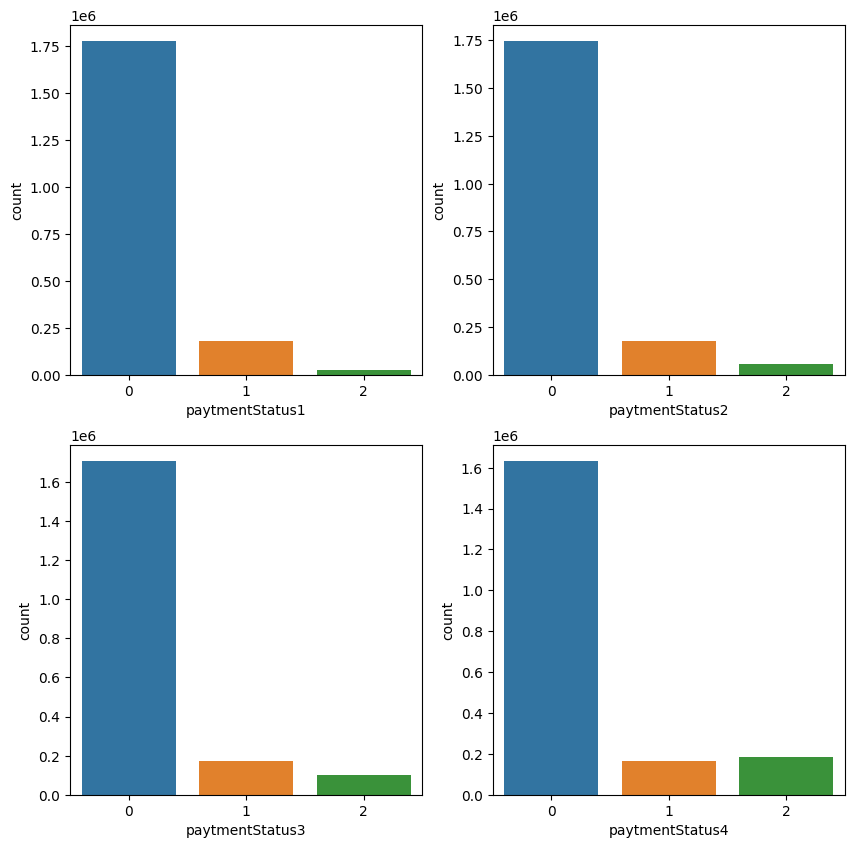

In [111]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sns.countplot(x=df.paytmentStatus1, ax=axs[0][0])
sns.countplot(x=df.paytmentStatus2, ax=axs[0][1])
sns.countplot(x=df.paytmentStatus3, ax=axs[1][0])
sns.countplot(x=df.paytmentStatus4, ax=axs[1][1]);

Let's see some movements between paymentStatuses.

In [153]:
payments = [(1,2), (2,3), (3,4)]

for idx1, idx2 in payments:
    print(pd.crosstab(index=df[f"paytmentStatus{idx1}"], columns= df[f"paytmentStatus{idx2}"], normalize="index"))
    print("\n")

paytmentStatus2         0         1         2
paytmentStatus1                              
0                0.896371  0.087891  0.015738
1                0.860904  0.123460  0.015636
2                0.000000  0.000000  1.000000


paytmentStatus3         0         1         2
paytmentStatus2                              
0                0.889878  0.087173  0.022950
1                0.855461  0.122895  0.021644
2                0.000000  0.000000  1.000000


paytmentStatus4         0         1         2
paytmentStatus3                              
0                0.870794  0.085763  0.043443
1                0.836757  0.120683  0.042561
2                0.000000  0.000000  1.000000




Main conclusions:
- If client defaulted in some point in time - there is no way this transaction cures (leaves default)
- There is, surprisingly no much difference in default rate for consequative payments for statuses 0 and 1. So, if client is late with a payment, then he/she tend to be late with another payment more, but goes to default rather with the same tendency as those with paytmentStatus = 0. 
- Default rate is rather not high, we may expect unbalanced target, which is normal for Credit Risk tasks.

Let's calculate the target. Default will be our target, from what we saw in our cross tables, there is no way client leaves default if client went there, so it's enough just to check the last payment status to determine whether it's defaulted one.

In [152]:
df["default"] = np.where(df.paytmentStatus4 == 2, 1, 0)
df.head()

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income,default
0,1,114,2869,140,0,0,0,0,2,24,74 Ada Street,74 Ada Street,54900.0,0
1,2,855,124077,70,0,0,0,0,1,46,23 Brampton Street,23 Brampton Street,60000.0,0
2,3,752,86184,85,0,0,0,0,1,52,96 Avon Street,35 Spurwood Street,7100.0,0
3,4,246,248861,43,1,0,0,0,1,29,3 Merinda Street,3 Merinda Street,67600.0,0
4,5,973,162112,127,0,0,0,0,2,30,64 Distribution Street,64 Distribution Street,92000.0,0


In [167]:
# sanity check: Seems ok
assert df[(df[pstatuses].apply(lambda x: max(x), axis=1) == 2) & (df.default == 0)].shape[0] == 0

#### Univariate EDA

In [170]:
# shops are relatively balanced
df.shopID.value_counts()

847    2352
280    2332
589    2331
234    2321
870    2319
       ... 
256    2077
419    2074
373    2074
276    2071
248    2064
Name: shopID, Length: 900, dtype: int64

In [172]:
# There are regular and one-time clients
df.customerID.value_counts()

61875     16
270525    16
47943     15
110021    15
467917    15
          ..
204578     1
427555     1
9293       1
343136     1
411107     1
Name: customerID, Length: 490533, dtype: int64

`Income` and `price` are distributed rather equally, `sex` is biased towards men. About `age` there was already a short comment about strange gap in the middle age.

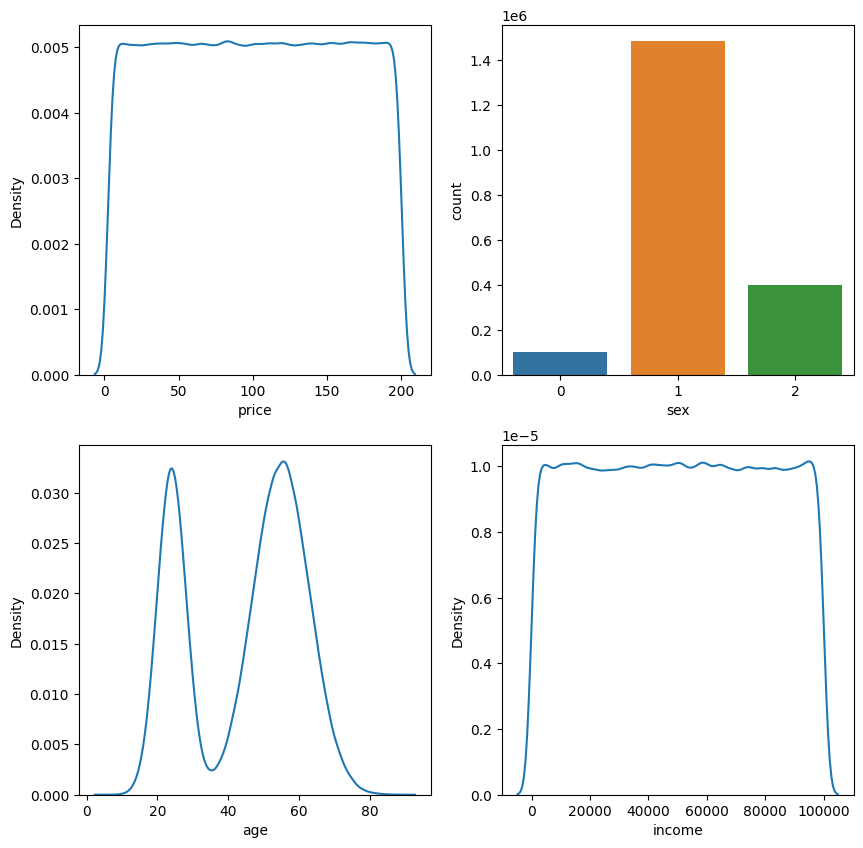

In [179]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
sns.kdeplot(x=df.price, ax= axs[0][0])
sns.countplot(x=df.sex, ax= axs[0][1])
sns.kdeplot(x=df.age, ax= axs[1][0])
sns.kdeplot(x=df.income, ax= axs[1][1]);

In [206]:
df[["price", "income"]].describe()

,price,income
count,1.979983e+06,1.940494e+06
mean,1.015208e+02,4.999000e+04
std,5.717817e+01,2.890984e+04
min,3.000000e+00,0.000000e+00
25%,5.200000e+01,2.490000e+04
50%,1.020000e+02,5.000000e+04
75%,1.510000e+02,7.500000e+04
max,2.000000e+02,1.000000e+05


Minimal price is 3? Seems like an outlier, probably this is some kind of a mistake. Did we initiated loan for a customer with 0 income? Do clients give their monthly or annual salary?

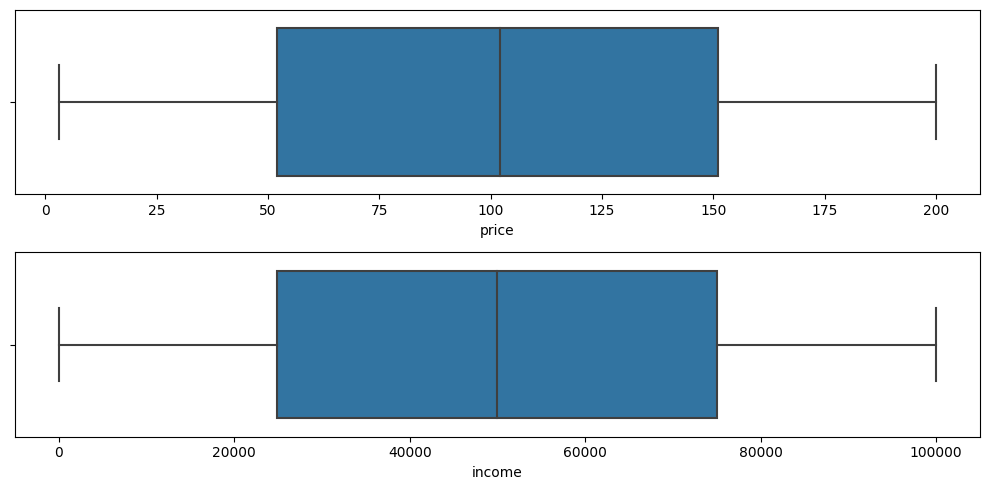

In [222]:
fig, axs = plt.subplots(2, 1, figsize=(10,5))
sns.boxplot(x=df.price, ax = axs[0])
sns.boxplot(x=df.income, ax = axs[1])
plt.tight_layout()

In [187]:
# As expected, target classes are disbalanced
df.default.value_counts(normalize=True)

0    0.907967
1    0.092033
Name: default, dtype: float64

In [191]:
# Are residentialAddress and postalAddress differenct sometimes?
print(df[(df.residentialAddress != df.postalAddress ) & (df.postalAddress != '')].shape)
df[(df.residentialAddress != df.postalAddress ) & (df.postalAddress != '')].head()

(97142, 14)


,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income,default
2,3,752,86184,85,0,0,0,0,1,52,96 Avon Street,35 Spurwood Street,7100.0,0
18,19,142,286888,71,0,2,2,2,2,37,7 Ardara Street,72 Baskerville Street,24700.0,1
52,55,872,3391,12,0,0,0,0,0,23,84 Belford Street,64 Junction Street,68100.0,0
83,86,686,308573,65,0,0,0,0,1,44,52 Bassano Street,65 Avadne Road,41700.0,0
87,90,710,206804,132,0,0,0,0,1,60,94 Suffolk Place,30 Seventeen mile rocks Road,48100.0,0


In [192]:
len(np.unique(df.residentialAddress))

389995

In [193]:
df.residentialAddress.value_counts()

43 Boundary Road        50
4 Park Road             49
92 Victoria Street      49
54 Boundary Road        48
45 Clifton Street       46
                        ..
43 Harrison Crescent     1
23 Dyne Street           1
89 Cambus Street         1
15 Wood Avenue           1
99 Purcell Lane          1
Name: residentialAddress, Length: 389995, dtype: int64

### Multivariate EDA

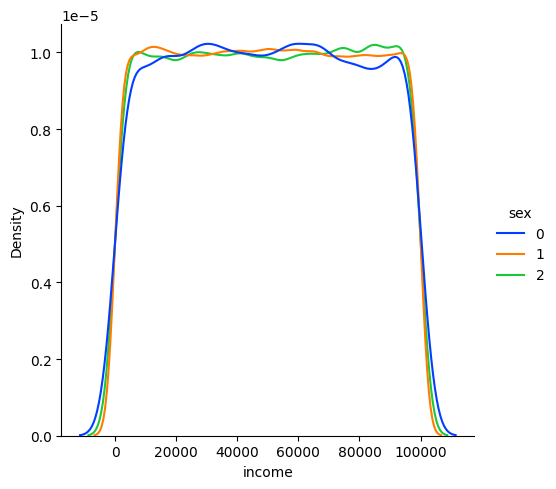

In [196]:
# Seems like there is no dependancy between sex and income
sns.displot(customers, x="income", hue="sex", kind="kde", common_norm=False, palette=sns.color_palette("bright", 3));

In [198]:
# Strange, there is no correlation beween age and income. Is this data synthetic?
df[["income", "age"]].corr()

,income,age
income,1.000000,0.001083
age,0.001083,1.000000


In [200]:
# Strange, there is no correlation beween price and income. Is this data synthetic?
df[["income", "price"]].corr()

,income,price
income,1.000000,0.001872
price,0.001872,1.000000


##### **Default related analysis**

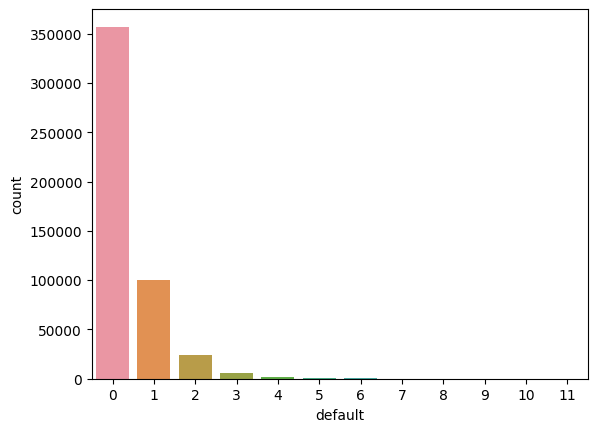

In [204]:
# Do we have customers who defaulted more than once?
sns.countplot(x=df.groupby("customerID").default.sum());

Some customers went in default more than once. Why do we approve their applications after the first default?

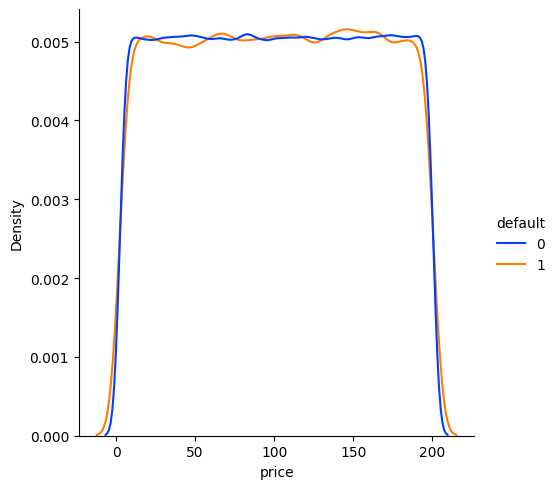

In [224]:
# Is there a dependancy between price and default?
sns.displot(df, x="price", hue="default", kind="kde", common_norm=False, palette=sns.color_palette("bright", 2));

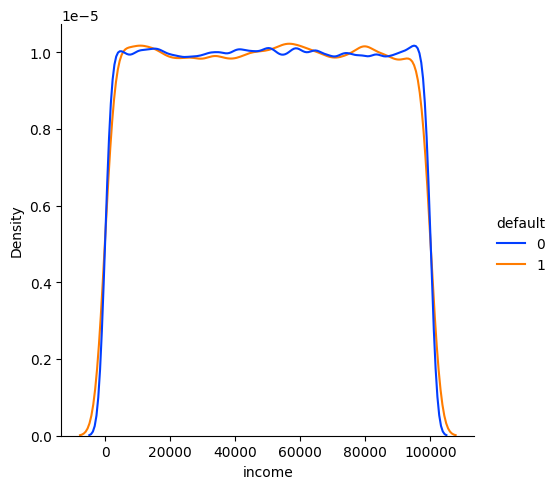

In [225]:
# Is there a dependancy between income and default?
sns.displot(df, x="income", hue="default", kind="kde", common_norm=False, palette=sns.color_palette("bright", 2));

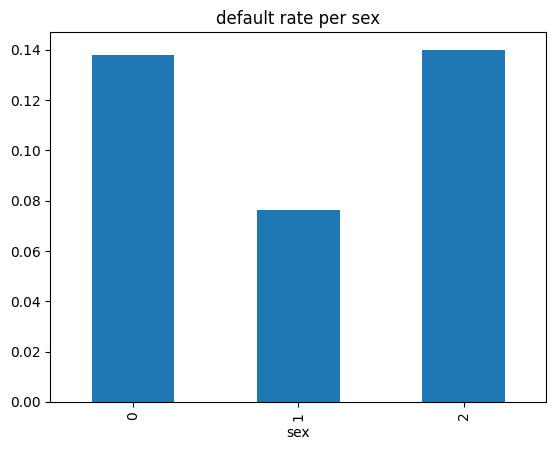

In [232]:
# Seems like women tend to default more frequently than men
df.groupby("sex").default.mean().plot(kind="bar", title="default rate per sex");

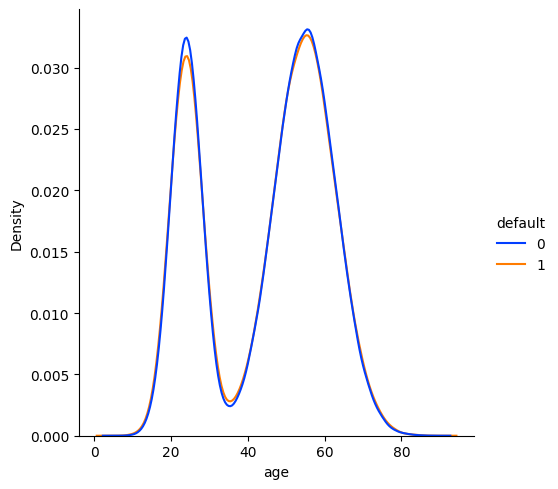

In [233]:
# Is there a dependancy between age and default?
sns.displot(df, x="age", hue="default", kind="kde", common_norm=False, palette=sns.color_palette("bright", 2));

In [277]:
# Customers who defaulted earlier tend to go default more?
df.sort_values(["customerID", "transactionID"], inplace=True)
df["defaulted_earlier"] = np.where(df.sort_values("transactionID").groupby(["customerID"]).default.expanding().sum().values > 1, 1, 0)
df.reset_index(drop=True, inplace=True)

df.groupby("defaulted_earlier").default.mean()

defaulted_earlier
0    0.070502
1    0.569281
Name: default, dtype: float64

In [290]:
# Customers who went to overdue earlier tend to go default more?
pstatuses = ["paytmentStatus1","paytmentStatus2","paytmentStatus3","paytmentStatus4"] 
df["late"] = np.where(df[pstatuses].max(axis=1) > 0, 1, 0)
df["late_earlier"] = np.where(df.sort_values("transactionID").groupby(["customerID"]).late.expanding().sum().values > 1, 1, 0)

df[df.defaulted_earlier == 0].groupby("late_earlier").default.mean()

late_earlier
0    0.064710
1    0.087264
Name: default, dtype: float64

In [281]:
df.head()

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income,default,defaulted_earlier,late,late_earlier
0,119294,634,1,88,0,0,0,0,1,25,28 Irvine Place,28 Irvine Place,NaN,0,0,0,0
1,832074,942,1,177,1,0,0,0,1,25,28 Irvine Place,28 Irvine Place,NaN,0,0,1,0
2,868540,361,1,93,0,0,0,0,1,25,28 Irvine Place,28 Irvine Place,NaN,0,0,0,0
3,1697842,248,1,147,0,0,0,0,1,25,28 Irvine Place,28 Irvine Place,NaN,0,0,0,0
4,983409,741,2,71,1,0,0,0,1,19,72 Bertha Street,72 Bertha Street,43200.0,0,0,1,0


#### **Main conclusions after EDA**

- Data seems to be synthetical, `price` and `income` look like randomly sampled from Uniform distribution from some range.
- There is a high dependancy between `sex` and tendency to `default`. Women tend to go default more.
- `Age` variable has very strange distribution, there are almost no customers of middle age. Besides, there is no dependancy of `default` from `age`. Moreover there is no dependancy of `income` of `age`, which is probably a result of artificially created data.
- Clients who were in default previously tend to default again with probability over 56%. Those who were late with an installment for previous loans tend to default more than those without any overdue in history, even though the difference is not huge.
- `customerID` should not be used as a feature, because we want to use a model for new customers, besides, this variable has quite high dimensionality.
- There is no strong dependancy between being just late with instalment and going to default. In other words, if the customer has an overdue, still with high probability he/she will pay the loan and most probably in time.

In [339]:
df.describe()

,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,income,default,defaulted_earlier,late,late_earlier,price_income
count,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.940494e+06,1.979983e+06,1.979983e+06,1.979983e+06,1.979983e+06,1940494.00
mean,5.492294e+02,2.500951e+05,1.015208e+02,1.175833e-01,1.473851e-01,1.896400e-01,2.685341e-01,1.150208e+00,4.463079e+01,4.999000e+04,9.203261e-02,4.316754e-02,3.713441e-01,2.888717e-01,inf
std,2.598552e+02,1.442889e+05,5.717817e+01,3.607263e-01,4.278684e-01,5.054030e-01,6.168379e-01,4.783529e-01,1.617545e+01,2.890984e+04,2.890720e-01,2.032342e-01,4.831643e-01,4.532383e-01,NaN
min,1.000000e+02,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00
25%,3.240000e+02,1.251390e+05,5.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.700000e+01,2.490000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.10
50%,5.490000e+02,2.500960e+05,1.020000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+01,5.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.20
75%,7.740000e+02,3.750930e+05,1.510000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.800000e+01,7.500000e+04,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.41
max,9.990000e+02,5.000000e+05,2.000000e+02,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.000000e+01,1.000000e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,inf


In [346]:
df.price.describe(percentiles=[0.01, 0.1, 0.15]).apply("{0:.5f}".format)

count    1979983.00000
mean         101.52084
std           57.17817
min            3.00000
1%             4.00000
10%           22.00000
15%           32.00000
50%          102.00000
max          200.00000
Name: price, dtype: object